In [ ]:
%qtconsole

# Expectation Maximization (theory)
Please see slides 14-15 in `ML-Clustering-L2.pdf` for an explanation of the Expecation Maximization algorithm. Let $D = \{x_1,...,x_n\}\subseteq \mathbb{R}^d$. Recall that in the EM algorithm we represent a cluster $C_i$ by a Gaussian distribution whose density function is given by

$$
\Pr(x|C_i) = \frac{1}{\sqrt{(2\pi)^d|\Sigma_i|}}\cdot e^{-\frac{1}{2}\cdot (x-\mu_i)^\intercal\cdot (\Sigma_i)^{-1}\cdot (x-\mu_i)}.
$$

Each cluster $C_i$ is parameterized with a cluster mean $\mu_i\in\Bbb R^d$, a covariance matrix $\Sigma_i\in\Bbb R^{d\times d}$ and a prior probability $\Pr(C_i)$.

<!--Given a clustering $M = \{C_1,\ldots,C_k\}$, we can compute
$$
\Pr(x) = \sum_{i=1}^k \Pr(C_i)\cdot\Pr(x|C_i),
$$
where we estimate $\Pr(C_i)$ by $W_i$, the frequency of the cluster $C_i$ in the data (i.e. the ratio of data points belonging to cluster $C_i$).-->

The Expectation Maximization has two steps: Expectation and Maximization (hence the name). Before this step we need to initialize an initial clustering $M = \{C_1,\ldots,C_k\}$. This is done as follows: 
- Choose cluster mean $\mu_i\in\Bbb R^d$ uniformly at random (in the adequate region). 
- Initialize the covariance matrix $\Sigma_i\in\Bbb R^{d\times d}$ as the identity matrix. 
- Initialize the prior probability $\Pr(C_i)$ is to $\frac{1}{k}$. 


Then we repeat the following two steps until the sum $\sum_{i=1}^k \|\mu_i - \mu'_i\|$ is below certain prespecified threshold $\epsilon$ (where $\mu'_i$ and $\mu_i$ are the means computed in two consecutive executions).

- <b>Update probabilities (expectation step):</b> For each all pairs $C_i$ and $x_j$ compute $\Pr(C_i|x_j) = \frac{\Pr(x_j|C_i)\cdot \Pr(C_i)}{\Pr(x_j)}$. <br>
  To do this we need to compute $\Pr(x_j|C_i)$ and $\Pr(x_j)$. Compute $\Pr(x_j|C_i)$ by the formula above, and compute $\Pr(x)$ by $\Pr(x)= \sum_{i=1}^k \Pr(C_i)\cdot\Pr(x|C_i)$.<br><br>
  
- <b>Update clustering (maximization step): </b>Compute a new model $M = \{C_1,\ldots, C_k\}$ by recomputing $W_i$, $\mu_i$ and $\Sigma_i$ as

$$
W_i = \frac{1}{n}\cdot\sum_{x\in D}\Pr(C_i|x)\approx P(C_i),
\qquad
\mu_i = \frac{\sum_{x\in D}^n x\Pr(C_i|x)}{\sum_{x\in D} \Pr(C_i|x)},
\qquad
\Sigma_i = \frac{\sum_{x\in D} \Pr(C_i|x)\cdot(x-\mu_i)\cdot(x-\mu_i)^\intercal}{\sum_{x\in D} \Pr(C_i|x)}.
$$

<b>Question 1:</b> What is the objective of Expectation Maximization (EM) clustering problem? 

HINT: See slides pages 14-15. 

<!--<b>Question 1 (b): </b>Rewrite the objective for $\text{dist}(x,y)=||x-y||$-->

<b>Question 2:</b> What are the E-step, M-step? What is estimated, what is fixed?

<b>Question 3:</b> Does EM algorithm provide any guarantees for finding the optimal solution?

HINT: What is the optimal solution? 

<b>Question 4:</b> Can a cluster of a EM clustering be empty? 

HINT: Since we are dealing with probabilities, what would it mean for a cluster to be 'empty'?

<b>Question 5:</b> In which of the two step does the EM algorithm attempt to maximize the objective function?

<b>Question 6:</b> Is EM algorithm guaranteed to converge? 

HINT: Assume the objective is strictly decreasing. 

<b>Question 7 (a): </b>How is Expectation Maximization Clustering a generalizaton of k-means clustering?

HINT: See the book [ZM] page 351. 

<b>Question 7 (b): </b>Could we assign a "hard clustering" of all points instead of a probability?

HINT: Which cluster is it most likely that $x_i$ belongs to?

<b>Question 7 (c): </b>Both models rely on certain assumptions on the data. What are these assumptions? Which assumptions are shared?

<b>Question 7 (d): </b>Give examples of data where the assumptions of k-means clustering and EM clustering are reasonable/unreasonable. (relevant for the exam)

<b>Bonus Question (Hard): </b>Baum-Welch training of Hidden Markov Models was also called Expectation Maximization. Are there any similarities/differences between the EM algorithm above and the Baum-Welch EM algorithm?

<!--
TODO: Some question that I thought about which would be nice to have is like a discussion about the differences between Kmeans and EM. The book points out (page 353) that EM is some kind of generalization of Kmeans, so in some sense it's more versatil (for example, it doesn't restrict us to convex clusters -right?- and it seems like the fact that the clusters are ''randomized'' allows us to do more things). What are the advantages/disadvantages of each? -->

# Expectation Maximization (code)
In this exercise you must implement the EM algorithm. To test our implementation we will need data. Like last week we use the Iris dataset. Recall that the dataset has three clases so we <i>cheat</i> by setting $k=3$.

In [2]:
# Load the Iris data set
import sklearn.datasets
iris = sklearn.datasets.load_iris()
X = iris['data'][:,0:2] # reduce dimensions so we can plot what happens.
k = 3
print(X.shape)

(150, 2)


## Implementing EM algorithm
Remember the Expectation Maximization algorithm has two steps. Let us first implement the Expectation step. For this step it suffices to compute $\Pr(C_i\mid x_j)$ for $i=1,\ldots,k$ and $j=1,\ldots n$. Remember that $\Pr(C_i \mid x_j)$ can be computed as 

$$\Pr(C_i|x_j) = \frac{\Pr(x_j|C_i)\cdot \Pr(C_i)}{\Pr(x_j)}$$

The first goal will then be to compute each part of the above equation. To do this we will need the parameters: ($\mu_i, \Sigma_i, \Pr(C_i)$). These will be represented in Python as follows: 

$$\text{means}=\begin{pmatrix}
- & \mu_1 & - \\
- & \vdots & - \\
- & \mu_k & - 
\end{pmatrix}\in \mathbb{R}^{k\times d} \quad\quad
\text{probs_c}=\begin{pmatrix}
\Pr(C_1)\\
\vdots \\
\Pr(C_k)
\end{pmatrix}\in \mathbb{R}^{k}
$$

Similarly we represent the $\Sigma_i$'s as $\text{covs}\in\mathbb{R}^{k\times d \times d}$ such that $\text{covs[i]}=\Sigma_i$. Finally we represent $\Pr(x)$'s and $\Pr(C_i \mid x)$ as 

$$\text{prob_x}=\begin{pmatrix}
\Pr(x_1) \\
\vdots \\
\Pr(x_n) 
\end{pmatrix}\in \mathbb{R}^{k\times d} \quad\quad
\text{probs_cx}=\begin{pmatrix}
\Pr(C_1\mid x_1) & \ldots & \Pr(C_1 \mid x_n)\\
\vdots \\
\Pr(C_k \mid x_1) & \ldots & \Pr(C_k \mid x_n)
\end{pmatrix}\in \mathbb{R}^{k}
$$

The function *compute_probs_cs* below takes `means`, `probs_c` and `covs` as input and returns `prob_cx` and `prob_x`. 

<b>Question: </b>What is the dimensions of `prob_cx` and how can we compute it given `means`, `probs_c` and `covs`?

<!-- The algorithm returns a clustering $M = \{C_1,\ldots,C_k\}$. This corresponds to a 
 - sequence of means $(\mu_1,\ldots,\mu_k)$ where each $\mu_i\in\Bbb R^d$,
 - sequence of covariance matrices $(\Sigma_1,\ldots,\Sigma_k)$ where each $\Sigma_i\in\Bbb R^{d\times d}$,
 - prior probabilities $(\Pr(C_1),\ldots,\Pr(C_k))$. 

Given $x$ we can then compute the probability of $x$ conditioned on the $i$'th cluster $Pr(C\mid x_i)$. If we want to assign $x$ to a specific cluster we compute $(\Pr(x|C_1),\ldots,\Pr(x|C_k))$ and assign $x$ to the `arg max`.-->

<!--The following helper function takes a description of a Gaussian Mixture ($\mu_i$'s, $\Sigma_i$'s and $\Pr(C_i)$'s)) and returns the probability densities of each point. We represent the inputs as 

If you want more information you can take a look at scipy's [multivariate_normal](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.multivariate_normal.html) documentation.-->

In [8]:
import numpy as np
from scipy.stats import multivariate_normal

def compute_probs_cx(points, means, covs, priors):
    '''
    Input
      - points: (n times d) array containing the dataset
      - means:  (k times d) array containing the k means
      - covs:   (k times d times d) array such that cov[j,:,:] is the covariance matrix of the j-th Gaussian.
      - priors: (k) array containing priors
    Output
      - probs:  (k times n) array such that the entry (i,j) represents Pr(C_i|x_j)
    '''
    # Convert to Nunmpy arrays.
    points, means, covs = np.asarray(points), np.asarray(means), np.asarray(covs)
    priors = np.asarray(priors)
    
    # Get sizes
    n, d = points.shape
    k = means.shape[0]
    
    # Make sure sizes are valid
    assert d == means.shape[1] == covs.shape[1] == covs.shape[2], "The dimensions of points, means, covs and priors should all be equal."
    assert k == covs.shape[0] == priors.shape[0], "The number of gaussians in means, covs and prios should all be equal."

    # Compute probabilities
    prob = []
    for i in range(k):
        if priors[i] < 1 / k ** 3:  
            prob.append(np.zeros(n))
        else:
            prob.append(
                priors[i] *
                multivariate_normal.pdf(
                    mean=means[i], cov=covs[i], x=points))
    
    # This will be a (k, n) matrix where the (i,j)'th entry is Pr(C_i)*Pr(x_j|C_i).
    prob = np.array(prob)
    assert prob.shape == (k, n)
    
    # The sum of the j'th column of this matrix is P(x_j); why?
    p_x = np.sum(prob, axis=0, keepdims=True) 
    assert p_x.shape == (1, n)
    
    # Divide the j'th column by P(x_j). The the (i,j)'th then 
    # becomes Pr(C_i)*Pr(x_j)|C_i)/Pr(x_j) = Pr(C_i|x_j)
    prob = prob / p_x

    # The sum of the j'th column should now sum to 1; why?
    #assert np.allclose(prob.sum(axis=0), 1)
    
    return prob, p_x


def pdf(points, mean, cov, prior):
    '''
    Input
      - points: (n times d) array containing the dataset
      - mean: (k times d) array containing the k means
      - cov: (k times d times d) array such that cov[j,:,:] is the covariance matrix of the j-th Gaussian
    
    Output
      - prob: (n times k) array such that the entry (i,j) represents Pr(x_i|C_j)
    '''
    points, mean, cov = np.asarray(points), np.asarray(mean), np.asarray(cov)
    prior = np.asarray(prior)
    n, d = points.shape
    k, d_1 = mean.shape
    k_2, d_2, d_3 = cov.shape
    k_3, = prior.shape
    assert d == d_1 == d_2 == d_3
    assert k == k_2 == k_3, "%s %s %s should be equal" % (k, k_2, k_3)

    # Compute probabilities
    prob = []
    for i in range(k):
        if prior[i] < 1 / k ** 3: # TODO: Why is this filter here?
            prob.append(np.zeros(n))
        else:
            prob.append(
                prior[i] *
                multivariate_normal.pdf(
                    mean=mean[i], cov=cov[i], x=points))
    prob = np.transpose(prob)  # n x k
    # Normalize cluster probabilities of each point
    prob = prob / np.sum(prob, axis=1, keepdims=True)  # n x k

    assert prob.shape == (n, k)
    assert np.allclose(prob.sum(axis=1), 1)
    return prob

The following is the basic structure for the EM algorithm. For the Expectation step it calls the above code. You need to finish the Maximization step 

<b>Question: </b>Where in the code (and how) do we initialize `means`, `covs` and `probs_c`?

In [4]:
def em_algorithm(X, k, T, epsilon = 0.001, means=None):
    """ Clusters the data X into k clusters using the Expectation Maximization algorithm. 
    
        Parameters
        ----------
        X : Data matrix of shape (n, d)
        k : Number of clusters.
        T : Maximum number of iterations
        epsilon :  Stopping criteria for the EM algorithm. Stops if the means of
                   two consequtive iterations are less than epsilon.
        means : (k times d) array containing the k initial means (optional)
        
        Returns
        -------
        means:     (k, d) array containing the k means
        covs:      (k, d, d) array such that cov[j,:,:] is the covariance matrix of 
                   the Gaussian of the j-th cluster
        probs_c:   (k, ) containing the probability Pr[C_i] for i=0,...,k. 
        llh:       The log-likelihood of the clustering (this is the objective we want to maximize)
    """
    n, d = X.shape
    
    # Initialize and validate mean
    if means is None: 
        means = np.random.rand(k, d)

    # Initialize cov, prior
    probs_x  = np.zeros(n) 
    probs_cx = np.zeros((k, n)) 
    probs_c  = np.zeros(k) + np.random.rand(k)
    
    covs = np.zeros((k, d, d))
    for i in range(k): covs[i] = np.identity(d)
    probs_c = np.ones(k) / k
    
    # Column names
    print("Iterations\tLLH")
    
    close = False
    old_means = np.zeros_like(means)
    iterations = 0
    while not(close) and iterations < T:
        old_means[:] = means 

        # Expectation step
        probs_cx, probs_x = compute_probs_cx(X, means, covs, probs_c)
        assert probs_cx.shape == (k, n)
        
        # Maximization step
        # YOUR CODE HERE
        for i in range(0, k):
            row = probs_cx[i, :]
            assert row.shape == (n,), row.shape
            sum_x_probs_cx = sum(row)
            
            probs_c[i] = 1/n * sum_x_probs_cx
            means[i]   = sum([X[j]*probs_cx[i,j] for j in range(n)]) / sum_x_probs_cx
            covs[i]    = sum([probs_cx[i,j]*np.outer(X[j]-means[i], X[j]-means[i]) for j in range(n)]) / sum_x_probs_cx
        # END CODE
        
        # Compute per-sample average log likelihood (llh) of this iteration     
        llh = 1/n*np.sum(np.log(probs_x))
        print(iterations+1, "\t\t", llh)

        # Stop condition
        dist = np.sqrt(((means - old_means) ** 2).sum(axis=1))
        close = np.all(dist < epsilon)
        iterations += 1
        
    # Validate output
    assert means.shape == (k, d)
    assert covs.shape == (k, d, d)
    assert probs_c.shape == (k,)
    return means, covs, probs_c, llh

# Load the Iris data set
import sklearn.datasets
iris = sklearn.datasets.load_iris()
X = iris['data'][:,0:2] # reduce dimensions so we can plot what happens.
k = 3

means, covs, priors, llh = em_algorithm(X, 3, 100, 0.001)

Iterations	LLH
1 		 -20.1868380674
2 		 -1.81708499496
3 		 -1.7987042403
4 		 -1.79722830966
5 		 -1.79485326747
6 		 -1.79091948774
7 		 -1.78418668249
8 		 -1.77241941517
9 		 -1.75353145989
10 		 -1.73190272459
11 		 -1.71684629874
12 		 -1.70894019854
13 		 -1.70485963704
14 		 -1.70261510493
15 		 -1.70123532643
16 		 -1.70022245101
17 		 -1.69934775365
18 		 -1.69854623897
19 		 -1.69783645006
20 		 -1.69725418532
21 		 -1.69681301848
22 		 -1.69649881898
23 		 -1.69628343058
24 		 -1.69613826485
25 		 -1.69604058504
26 		 -1.69597433108
27 		 -1.69592879479
28 		 -1.69589700742
29 		 -1.69587445842
30 		 -1.69585821308
31 		 -1.69584634043
32 		 -1.69583755129
33 		 -1.69583097081
34

/home/ubudevml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide
/home/ubudevml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in less


 		 -1.69582599531
35 		 -1.69582220131
36 		 -1.69581928709
37 		 -1.69581703458
38 		 -1.69581528413
39 		 -1.69581391748
40 		 -1.69581284617
41 		 -1.69581200343
42 		 -1.69581133845
43 		 -1.69581081233
44 		 -1.69581039507
45 		 -1.69581006347
46 		 -1.69580979946
47 		 -1.6958095889
48 		 -1.69580942074
49 		 -1.69580928626
50 		 -1.6958091786
51 		 -1.69580909231
52 		 -1.69580902309
53 		 -1.69580896751
54 		 -1.69580892286
55 		 -1.69580888697
56 		 -1.69580885809
57 		 -1.69580883485
58 		 -1.69580881613
59 		 -1.69580880105
60 		 -1.6958087889
61 		 -1.69580877911
62 		 -1.69580877121
63 		 -1.69580876483
64 		 -1.69580875969
65 		 -1.69580875554
66 		 -1.69580875219
67 		 -1.69580874949
68 		 -1.69580874731
69 		 -1.69580874554
70 		 -1.69580874412
71 		 -1.69580874297
72 		 -1.69580874204
73 		 -1.69580874129
74 		 -1.69580874068
75 		 -1.69580874019
76 		 -1.6958087398
77 		 -1.69580873948
78 		 -1.69580873922
79 		 -1.69580873901
80 		 -1.69580873884
81 		 -1.6958087387

The random initialization usually causes the algorithm to get stuck at different local maximum. This causes different runs to get different scores. In practice this is usually handled by running the algorithm several times and picking the best run. 

The following code runs EM algorithm 50 times and plots the score of each run. Because the data set is fairly small, $n=150$, most of the runs will get the same score. 

<IPython.core.display.Javascript object>


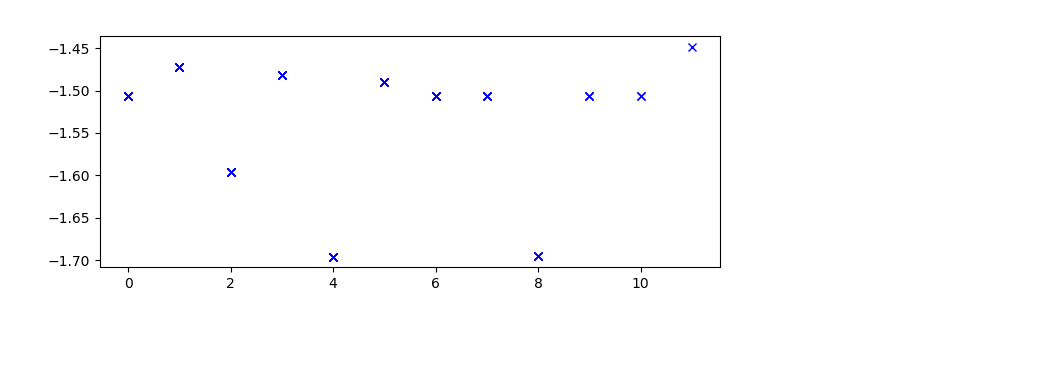

Iterations	LLH
1 		 -17.7930881588
2 		 -1.80899891676
3 		 -1.80008815067
4 		 -1.79951047197
5 		 -1.79853982133
6 		 -1.79682005614
7 		 -1.79375079436
8 		 -1.78850851976
9 		 -1.78057719702
10 		 -1.77056283392
11 		 -1.75949989023
12 		 -1.74730122917
13 		 -1.73243296136
14 		 -1.71185777382
15 		 -1.68057548738
16 		 -1.63094702173
17 		 -1.56263904981
18 		 -1.51735037758
19 		 -1.50791231231
20 		 -1.50685371048
21 		 -1.50675431865
22 		 -1.50674607459
23 		 -1.50674541956
24 		 -1.50674536815
25 		 -1.50674536412
26 		 -1.50674536381
27 		 -1.50674536379
28 		 -1.50674536378
29 		 -1.50674536378
30 		 -1.50674536378
31 		 -1.50674536378
32 		 

/home/ubudevml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/home/ubudevml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in less


-1.50674536378
33 		 -1.50674536378
34 		 -1.50674536378
35 		 -1.50674536378
36 		 -1.50674536378
37 		 -1.50674536378
38 		 -1.50674536378
39 		 -1.50674536378
40 		 -1.50674536378
41 		 -1.50674536378
42 		 -1.50674536378
43 		 -1.50674536378
44 		 -1.50674536378
45 		 -1.50674536378
46 		 -1.50674536378
47 		 -1.50674536378
48 		 -1.50674536378
49 		 -1.50674536378
50 		 -1.50674536378
51 		 -1.50674536378
52 		 -1.50674536378
53 		 -1.50674536378
54 		 -1.50674536378
55 		 -1.50674536378
56 		 -1.50674536378
57 		 -1.50674536378
58 		 -1.50674536378
59 		 -1.50674536378
60 		 -1.50674536378
61 		 -1.50674536378
62 		 -1.50674536378
63 		 -1.50674536378
64 		 -1.50674536378
65 		 -1.50674536378
66 		 -1.50674536378
67 		 -1.50674536378
68 		 -1.50674536378
69 		 -1.50674536378
70 		 -1.50674536378
71 		 -1.50674536378
72 		 -1.50674536378
73 		 -1.50674536378
74 		 -1.50674536378
75 		 -1.50674536378
76 		 -1.50674536378
77 		 -1.50674536378
78 		 -1.50674536378
79 		 -1.5067453637

74 		 -1.49023903891
75 		 -1.49022418797
76 		 -1.49021050363
77 		 -1.49019789729
78 		 -1.49018628617
79 		 -1.49017559316
80 		 -1.49016574656
81 		 -1.49015667988
82 		 -1.49014833154
83 		 -1.49014064461
84 		 -1.49013356653
85 		 -1.49012704878
86 		 -1.49012104665
Iterations	LLH
1 		 -20.1892034467
2 		 -1.81353966757
3 		 -1.79831714922
4 		 -1.79589537626
5 		 -1.7916626014
6 		 -1.7848331842
7 		 -1.77552324801
8 		 -1.76478741015
9 		 -1.75318507999
10 		 -1.73994074056
11 		 -1.72278249744
12 		 -1.69757531484
13 		 -1.65761473644
14 		 -1.59547743945
15 		 -1.5314298645
16 		 -1.50947053935
17 		 -1.50698449548
18 		 -1.50676518069
19 		 -1.50674694172
20 		 -1.50674548777
21 		 -1.50674537349
22 		 -1.50674536454
23 		 -1.50674536384
24 		 -1.50674536379
25 		 -1.50674536378
26 		 -1.50674536378
27 		 -1.50674536378
28 		 -1.50674536378
29 		 -1.50674536378
30 		 -1.50674536378
31 		 -1.50674536378
32 		 -1.50674536378
33 		 -1.50674536378
34 		 -1.50674536378
35 		 -1.5

LinAlgError: singular matrix

In [102]:
%matplotlib notebook 
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8,3))    
llhs = []

for i in range(100):
    _, _, _, llh = em_algorithm(X, 3, 100)
    llhs.append(llh)
    ax.plot(llhs, 'bx')
    fig.canvas.draw() #tODO: compute hard clustering and see kmeasn score?

To check your implementation you should run <a href="http://scikit-learn.org/stable/modules/mixture.html">sklearn</a>'s implementation of the EM algorithm. You might want to take a look at the documentation to get a better understanding of what the algorithm is actually doing.

<!--By default the implementation repeats the algorithm $10$ times and picks the best result. A sanity check for your implementation of Lloyd's algorithm is to check that the scores are roughly the same. -->

In [104]:
from sklearn.mixture import GaussianMixture as EM
expectation_maximization = EM(n_components=3, init_params='kmeans', covariance_type='diag', verbose=2, verbose_interval =1).fit(X)
print(expectation_maximization.score(X))

Initialization 0
  Iteration 0	 time lapse 0.00927s	 ll change inf
  Iteration 1	 time lapse 0.00073s	 ll change 0.02220
  Iteration 2	 time lapse 0.00076s	 ll change 0.00588
  Iteration 3	 time lapse 0.00080s	 ll change 0.00368
  Iteration 4	 time lapse 0.00081s	 ll change 0.00367
  Iteration 5	 time lapse 0.00076s	 ll change 0.00357
  Iteration 6	 time lapse 0.00054s	 ll change 0.00272
  Iteration 7	 time lapse 0.00085s	 ll change 0.00156
  Iteration 8	 time lapse 0.00071s	 ll change 0.00072
Initialization converged: True	 time lapse 0.01531s	 ll -1.62954
-1.62924957014


To get a visual understanding of the algorithm, the following code visualizes each step of the algorithm. Just copy and paste the answer from your implementation from above and run. Running the visualization might be a bit slow (it has a few bugs, will make it work ASAP). 

<IPython.core.display.Javascript object>


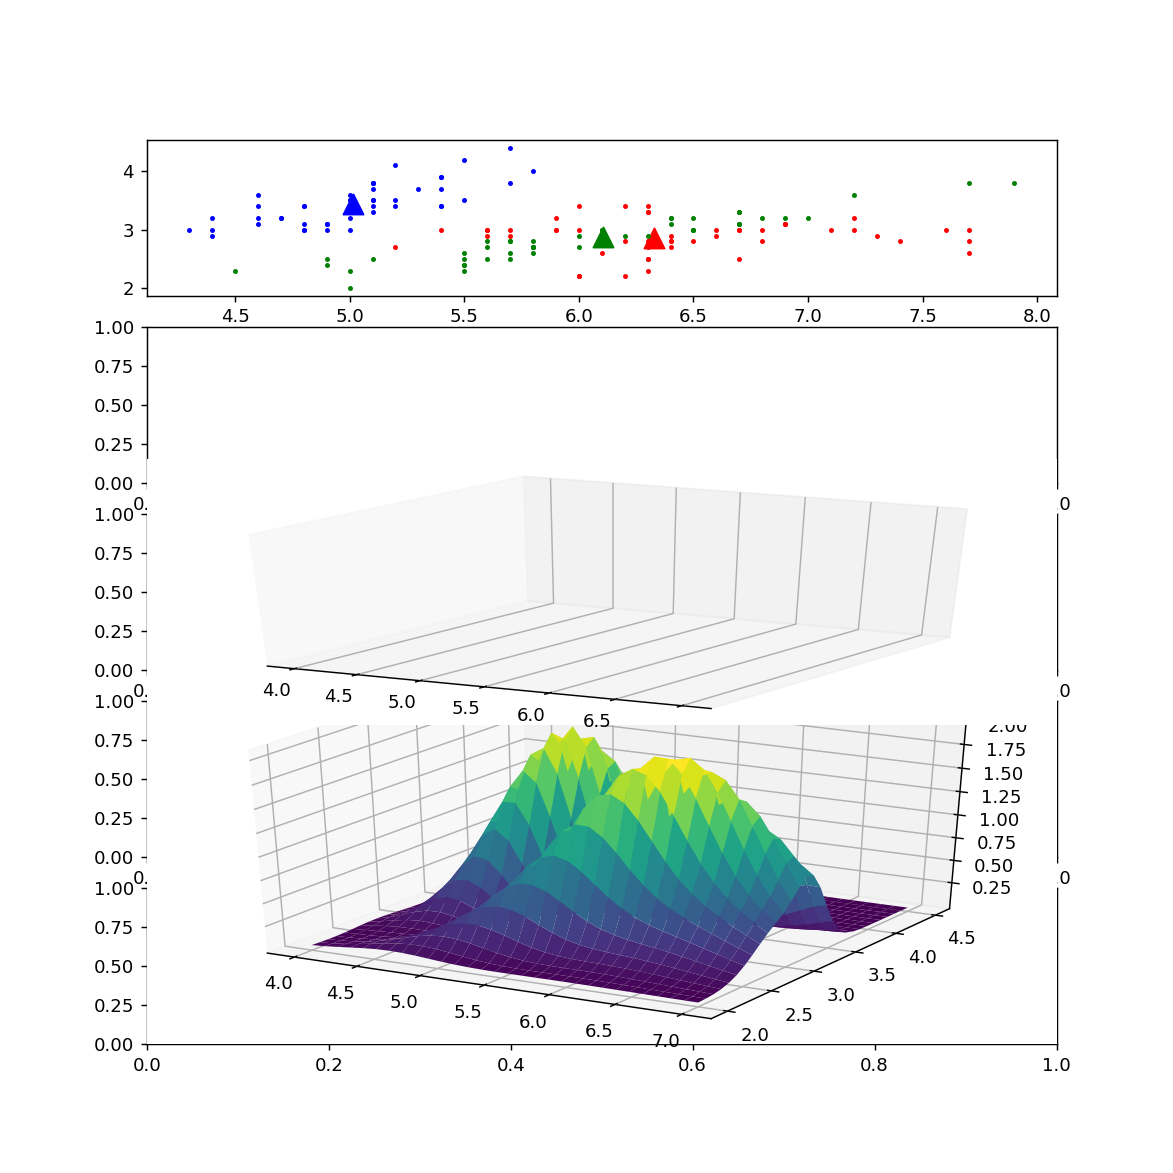

Iterations	LLH
1 		 -17.6459528237
2 		 -1.79959142706
3 		 -1.79816073942
4 		 -1.79591204335
5 		 -1.79208719881
6 		 -1.78577431805
7 		 -1.77617528301
8 		 -1.76273817217
9 		 -1.74421945579
10 		 -1.71899327925
11 		 -1.68888692827
12 		 -1.65537794529
13 		 -1.61788865206
14 		 -1.5736815519
15 		 -1.53158725829
16 		 -1.50650250513
17 		 -1.49521234467
18 		 -1.49009926261
19 		 -1.4872782865
20 		 -1.48549660549
21 		 -1.48433481993
22 		 -1.4835462002
23 		 -1.48297953461
24 		 -1.48255302868
25 		 -1.48222459343
26 		 -1.48197065598
27 		 -1.48177536406
28 		 -1.4816263076
29 		 -1.48151319984
30 		 -1.48142755529
31 		 -1.48136256007
32 		 -1.481312904
33 		 -1.48127455723
34 		 -1.48124452679
35 		 -1.48122062576
36 		 -1.48120127405
37 		 -1.48118533732
38 		 -1.48117200248
39 		 -1.48116068507
40 		 -1.48115096185
41 		 -1.48114252282


In [111]:
%matplotlib notebook 
import matplotlib.pyplot as plt
import numpy as np
import time
from mpl_toolkits.mplot3d import Axes3D

def em_algorithm_visualize(X, k, T, epsilon = 0.001, means=None):
    """ Clusters the data X into k clusters using the Expectation Maximization algorithm. 
    
        Parameters
        ----------
        X : Data matrix of shape (n, d)
        k : Number of clusters.
        T : Maximum number of iterations
        epsilon :  Stopping criteria for the EM algorithm. Stops if the means of
                   two consequtive iterations are less than epsilon.
        means : (k times d) array containing the k initial means (optional)
        
        Returns
        -------
        means:     (k, d) array containing the k means
        covs:      (k, d, d) array such that cov[j,:,:] is the covariance matrix of 
                   the Gaussian of the j-th cluster
        probs_c:   (k, ) containing the probability Pr[C_i] for i=0,...,k. 
        llh:       The log-likelihood of the clustering (this is the objective we want to maximize)
    """
    n, d = X.shape
    
    # Visualization stuff. 
    fig, (ax, _, _, _, _) = plt.subplots(5, 1, figsize=(9,9)) 
    ax.axis('off')
    colors = ["r", "g", "b"]
    ax3d = fig.add_subplot(2, 1, 2, projection='3d')
    ax3d1 = fig.add_subplot(3, 1, 2, projection='3d')
    ax3d2 = fig.add_subplot(4, 1, 2, projection='3d')
    ax3d3 = fig.add_subplot(5, 1, 2, projection='3d')
    
    # Initialize and validate mean
    if means is None: means = np.random.rand(k, d)

    # Initialize 
    probs_x  = np.zeros(n) 
    probs_cx = np.zeros((k, n)) 
    probs_c  = np.zeros(k) 
    covs = np.zeros((k, d, d))
    for i in range(k): covs[i] = np.identity(d)
    probs_c = np.ones(k) / k

    # END CODE
    
    # Column names
    print("Iterations\tLLH")
    
    close = False
    old_means = np.zeros_like(means)
    iterations = 0
    while not(close) and iterations < T:
        old_means[:] = means # This allows us to actually copy the array mean

        # Expectation step
        probs_cx, probs_x = compute_probs_cx(X, means, covs, probs_c)
        assert probs_cx.shape == (k, n)
        
        # Maximization step
        for i in range(0, k):

            # re-estimate means, covs and probs_c
            row = probs_cx[i, :]
            assert row.shape == (n,), row.shape
            sum_x_probs_cx = sum(row)
            
            probs_c[i] = 1/n * sum_x_probs_cx
            means[i]   = sum([X[j]*probs_cx[i,j] for j in range(n)]) / sum_x_probs_cx
            covs[i]    = sum([probs_cx[i,j]*np.outer(X[j]-means[i], X[j]-means[i]) for j in range(n)]) / sum_x_probs_cx
        
        # Compute the llh of this iteration
        # YOUR CODE HERE
        #llh = np.log(1/n * np.prod(probs_x))       
        llh = 1/n*np.sum(np.log(probs_x))
        # END CODE
        print(iterations+1, "\t\t", llh)

        # Finish condition
        dist = np.sqrt(((means - old_means) ** 2).sum(axis=1))
        close = np.all(dist < epsilon)
        iterations += 1
        
        # Extra code for visualization
        centroids = means
        # W matrix (i,j) says Pr[C_i, x_j]
        # assign each x_i to the cluster C_i that maximizes P(C_i x_j)
        clustering = np.argmax(probs_cx, axis=0)
        assert clustering.shape == (n,), clustering.shape
        
        # Draw clusters
        ax.cla()
        for j in range(k):
            centroid = centroids[j]
            c = colors[j]
            ax.scatter(centroid[0], centroid[1], s=123, c=c, marker='^')
            data = X[clustering==j]
            x = data[:,0]
            y = data[:,1]
            ax.scatter(x, y, s=3, c=c)
            
        # draw 3d gaussians. 
        #Create grid and multivariate normal
        xs = np.linspace(4,7, 30)
        ys = np.linspace(2,4.5, 30)
        Xs, Ys = np.meshgrid(xs, ys)
        pos = np.empty(Xs.shape + (2,))
        pos[:, :, 0] = Xs; pos[:, :, 1] = Ys
        prob_space = sum([multivariate_normal(means[j], covs[j]).pdf(pos) for j in range(k)])

        #Make a 3D plot
        ax3d.cla()
        ax3d1.cla()
        ax3d2.cla()
        ax3d3.cla()
        ax3d.plot_surface(Xs, Ys, prob_space, cmap='viridis', linewidth=0)
        ax3d1.plot_surface(Xs, Ys, multivariate_normal(means[0], covs[0]).pdf(pos), cmap='viridis', linewidth=0)
        ax3d2.plot_surface(Xs, Ys, multivariate_normal(means[1], covs[1]).pdf(pos), cmap='viridis', linewidth=0)
        ax3d3.plot_surface(Xs, Ys, multivariate_normal(means[2], covs[2]).pdf(pos), cmap='viridis', linewidth=0)
        
        fig.canvas.draw()    
        
    # Validate output
    assert means.shape == (k, d)
    assert covs.shape == (k, d, d)
    assert probs_c.shape == (k,)
    return means, covs, probs_c, llhs

# Load the Iris data set
import sklearn.datasets
iris = sklearn.datasets.load_iris()
X = iris['data'][:,0:2] # reduce dimensions so we can plot what happens.
k = 3

means, covs, priors, llh = em_algorithm_visualize(X, 3, 100, 0.001)

## Initializing EM with Lloyd's algorithm 

So far we have been initializing the means for the Expectation Maximization algorithm at random. We could also make a mix of Lloyd's algorithm and EM algorithm by running Lloyd's algorithm first to obtain the initial means for the EM algorithm. 

Begin by copying and pasting the implementation of Lloyd's algorithm from the previous week

In [ ]:
def lloyds_algorithm(X, k, T):
    """ Clusters the data of X into k clusters using T iterations of Lloyd's algorithm. 
    
        Parameters
        ----------
        X : Data matrix of shape (n, d)
        k : Number of clusters.
        T : Maximum number of iterations to run Lloyd's algorithm. 
        
        Returns
        -------
        clustering: A vector of shape (n, ) where the i'th entry holds the cluster of X[i].
        centroids:  The centroids/average points of each cluster. 
        cost:       The cost of the clustering 
    """
    pass

Then use this algorithm to initialize the means for the EM algorithm. For this notice that `em_algorithm` accepts an optional input for the initial means.

Also, notice that the sklearn's implementation of the EM algorithm can take this initialization into account. Can you look through the documentation and find out what lines should be changed when we used sklearn before? This would be very useful for testing and comparing your implementation above.

In [ ]:
# YOUR CODE HERE
# END CODE

<b>Question:</b> Why can we use Lloyd's algorithm to initialize the EM algorithm? Does it (always) give a better final clustering? If so, why is that the case?

## Evaluating the clustering using silhuette coefficient
In the lecture Ira talked about how one can compare different clusters.

In [ ]:
def silhouette(data, clustering): 
    n, d = data.shape
    k = np.unique(clustering)[-1]+1

    # YOUR CODE HERE
    silh = None
    # END CODE

    return silh

silhouette(X, clustering)

Calcualte the Silhouette coefficient for the EM clustering. 

# Clustering digits
In previous weeks we did supervised learning on images of digits. In this exercise we will perform clustering on digits. Remember clustering can be considered a type of unsupervised learning. The main difference to what we did before is that  will attempt to find patterns in the data without using the labels.  

You can use the AUDigits if you want. The following code uses a data set of images called MNIST. They are almost identical. The only reason for using MNIST is that we can import it with just two lines of code. 

In [9]:
import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/")

X = mnist.train.images
y = mnist.train.labels

print(X.shape)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
(55000, 784)


The following code runs the Expectation Maimization algorithm on 5000 images from the MNIST dataset. It then visualizes the found centroids. 

Initialization 0
  Iteration 0
  Iteration 1
  Iteration 2
  Iteration 3
  Iteration 4
  Iteration 5
  Iteration 6
  Iteration 7
  Iteration 8
  Iteration 9
Initialization converged: False
2244.56157157
(10, 784)


/home/ubudevml/anaconda3/lib/python3.6/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


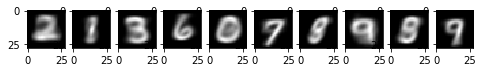

In [22]:
from sklearn.mixture import GaussianMixture as EM
import matplotlib.pyplot as plt

# One cluster for each digit
k = 10

# Run EM algorithm on 1000 images from the MNIST dataset. 

expectation_maximization = EM(n_components=k, max_iter=10, init_params='kmeans', covariance_type='diag', verbose=1, verbose_interval =1).fit(X)
print(expectation_maximization.score(X[:1000]))

means = expectation_maximization.means_
covs = expectation_maximization.covariances_
      
print(means.shape)
fig, ax = plt.subplots(1, k, figsize=(8, 1))

for i in range(k):
    ax[i].imshow(means[i].reshape(28, 28), cmap='gray')
    
plt.show()

<b>Question 1: </b>Why do the centroids look like images of digits? 
    
Because our clusters are represented as gaussians, it is possible to sample points from them. Think of this as rolling a dice, but instead of getting a number, you get a picture of a digit. The last line has a call to `sample`. The last parameter specifies which cluster to sample from. 

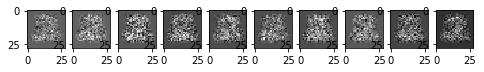

In [45]:
from scipy.stats import multivariate_normal
import numpy as np

def sample(means, covs, num):
    mean = means[num]
    cov = covs[num]
     
    fig, ax = plt.subplots(1, 10, figsize=(8, 1))
    
    for i in range(10):
        img = multivariate_normal.rvs(mean=mean, cov=cov) # draw random sample   
        ax[i].imshow(img.reshape(28, 28), cmap='gray') # draw the random sample
    plt.show()
    
sample(means, covs, 0) 